# Analysis

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras

In [2]:
# Pull and clean up traffic data for a city
def convert_traffic_data(city):
    # Load {city}.csv
    city_data = pd.read_csv(f'dataset/cities/{city}.csv')

    city_data['interval'] = city_data['interval'].apply(lambda x: f'{x // 3600}:{x % 3600 // 60}:{x % 60}')
    city_data['datetime'] = pd.to_datetime(city_data['day'] + ' ' + city_data['interval'], format='%Y-%m-%d %H:%M:%S')

    date_time = pd.to_datetime(city_data['day'] + ' ' + city_data['interval'])

    # Convert the datetime column to a timestamp
    timestamp = date_time.map(pd.Timestamp.timestamp)

    # Add the sin and cos of the day, week and year to the dataframe
    day = 24 * 60 * 60
    week = day * 7
    year = day * 365.2425
    city_data['day_sin'] = np.sin(timestamp * (2 * np.pi / day))
    city_data['day_cos'] = np.cos(timestamp * (2 * np.pi / day))
    city_data['week_sin'] = np.sin(timestamp * (2 * np.pi / week))
    city_data['week_cos'] = np.cos(timestamp * (2 * np.pi / week))
    city_data['year_sin'] = np.sin(timestamp * (2 * np.pi / year))
    city_data['year_cos'] = np.cos(timestamp * (2 * np.pi / year))

    # Drop the datetime and timestamp columns
    city_data = city_data.drop(columns=['interval', 'day', 'error', 'speed'])
    city_data = city_data.set_index(['city', 'detid', 'datetime'])

    return city_data

In [3]:
city_data = convert_traffic_data('frankfurt')
city_data.head()

flow       occ       day_sin   day_cos  \
city      detid  datetime                                                      
frankfurt BP2_D1 2016-12-21 00:00:00  24.0  0.004967 -3.377779e-12  1.000000   
                 2016-12-21 00:05:00  24.0  0.006900  2.181489e-02  0.999762   
                 2016-12-21 00:10:00  12.0  0.003567  4.361939e-02  0.999048   
                 2016-12-21 00:15:00  12.0  0.002667  6.540313e-02  0.997859   
                 2016-12-21 00:20:00  12.0  0.002267  8.715574e-02  0.996195   

                                      week_sin  week_cos  year_sin  year_cos  
city      detid  datetime                                                     
frankfurt BP2_D1 2016-12-21 00:00:00 -0.781831  0.623490 -0.177914  0.984046  
                 2016-12-21 00:05:00 -0.779884  0.625923 -0.177855  0.984057  
                 2016-12-21 00:10:00 -0.777930  0.628351 -0.177796  0.984067  
                 2016-12-21 00:15:00 -0.775968  0.630773 -0.177737  0.984078  
                 2016-12-21 00:20:00 -0.773998  0.633188 -0.177679  0.984089

In [4]:
# Expand detector data
def expand_detector_data(city_data):
    # Load detectors.csv
    detectors = pd.read_csv('dataset/detectors.csv').set_index(['citycode', 'detid'])

    # Add the detector data to the city data
    city_data = city_data.join(detectors, on=['city', 'detid'])
    city_data['linkid'] = city_data['linkid'].astype('int64')
    city_data['limit'] = city_data['limit'].astype('int64')

    # Drop the detector id column
    city_data = city_data.reset_index().drop(columns=['road', 'long', 'lat', 'detid']).set_index(['city', 'linkid', 'datetime'])

    # Convert the fclass column to a range
    fclass_ids = [
        'other', 
        'living_street', 
        'residential', 
        'service', 
        'tertiary_link', 
        'tertiary', 
        'secondary_link',
        'secondary', 
        'primary_link', 
        'primary',
        'trunk_lin'
        'trunk', 
        'motorway_link', 
        'motorway'
    ]
    city_data['fclass'] = city_data['fclass'].apply(lambda x: fclass_ids.index(x))

    return city_data

In [5]:
city_data = expand_detector_data(city_data)
city_data.head()

flow       occ       day_sin   day_cos  \
city      linkid datetime                                                      
frankfurt 29     2016-12-21 00:00:00  24.0  0.004967 -3.377779e-12  1.000000   
                 2016-12-21 00:05:00  24.0  0.006900  2.181489e-02  0.999762   
                 2016-12-21 00:10:00  12.0  0.003567  4.361939e-02  0.999048   
                 2016-12-21 00:15:00  12.0  0.002667  6.540313e-02  0.997859   
                 2016-12-21 00:20:00  12.0  0.002267  8.715574e-02  0.996195   

                                      week_sin  week_cos  year_sin  year_cos  \
city      linkid datetime                                                      
frankfurt 29     2016-12-21 00:00:00 -0.781831  0.623490 -0.177914  0.984046   
                 2016-12-21 00:05:00 -0.779884  0.625923 -0.177855  0.984057   
                 2016-12-21 00:10:00 -0.777930  0.628351 -0.177796  0.984067   
                 2016-12-21 00:15:00 -0.775968  0.630773 -0.177737  0.984078   
                 2016-12-21 00:20:00 -0.773998  0.633188 -0.177679  0.984089   

                                        length       pos  fclass  limit  lanes  
city      linkid datetime                                                       
frankfurt 29     2016-12-21 00:00:00  0.049609  0.016967       7     50    1.0  
                 2016-12-21 00:05:00  0.049609  0.016967       7     50    1.0  
                 2016-12-21 00:10:00  0.049609  0.016967       7     50    1.0  
                 2016-12-21 00:15:00  0.049609  0.016967       7     50    1.0  
                 2016-12-21 00:20:00  0.049609  0.016967       7     50    1.0

In [6]:
# Split the data into training, validation and test sets
def split_data(city_data):
    from sklearn.model_selection import train_test_split

    # Split the data into training, validation and test sets
    train_data, test_data = train_test_split(city_data, test_size=0.2, shuffle=False)
    train_data, val_data = train_test_split(train_data, test_size=0.2, shuffle=False)

    return train_data, val_data, test_data

train_data, val_data, test_data = split_data(city_data)

In [7]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_data, val_df=val_data, test_df=test_data,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                            enumerate(label_columns)}
            self.column_indices = {name: i for i, name in
                                enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
  
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)

        ds = ds.map(self.split_window)

        return ds
  
    def train(self):
        return self.make_dataset(self.train_df)

    def val(self):
        return self.make_dataset(self.val_df)

    def test(self):
        return self.make_dataset(self.test_df)

    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result
    
window = WindowGenerator(input_width=12, label_width=1, shift=12, label_columns=['flow'])
window

Total window size: 24
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Label indices: [23]
Label column name(s): ['flow']

In [8]:
# Create an LSTM model
def create_model(input_shape):
    from keras.models import Sequential
    from keras.layers import LSTM, Dense, Dropout

    model = Sequential([
        LSTM(32, input_shape=input_shape, return_sequences=True),
        Dense(1)
    ])

    model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['mean_absolute_error', 'mean_squared_error']
    )

    return model

# Create the model for hourly predictions
model = create_model(input_shape=(window.total_window_size//2, len(window.train_df.columns)))
model.summary()
print(model.input_shape)

2023-12-16 20:33:11.942849: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2023-12-16 20:33:11.942874: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2023-12-16 20:33:11.942882: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2023-12-16 20:33:11.942915: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-16 20:33:11.942929: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 32)            5888      
                                                                 
 dense (Dense)               (None, 12, 1)             33        
                                                                 
Total params: 5921 (23.13 KB)
Trainable params: 5921 (23.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
(None, 12, 13)


In [9]:
# Train the model
def train_model(model, window, epochs=100):
    from keras.callbacks import EarlyStopping

    early_stop = EarlyStopping(monitor='val_loss', patience=10)

    # Print model inputs and outputs
    print(f'Inputs: {model.input_shape}')
    print(f'Outputs: {model.output_shape}')

    history = model.fit(
        window.train(),
        epochs=epochs,
        validation_data=window.val(),
        callbacks=[early_stop]
    )

    return history

history = train_model(model, window)

Inputs: (None, 12, 13)
Outputs: (None, 12, 1)
Epoch 1/100


2023-12-16 20:33:12.810000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


613/613 [==============================] - 12s 17ms/step - loss: 104093.8203 - mean_absolute_error: 228.9820 - mean_squared_error: 104093.8516 - val_loss: 125700.2734 - val_mean_absolute_error: 246.8138 - val_mean_squared_error: 125700.3125
Epoch 2/100
613/613 [==============================] - 10s 16ms/step - loss: 94443.1328 - mean_absolute_error: 210.7775 - mean_squared_error: 94443.1484 - val_loss: 116864.3906 - val_mean_absolute_error: 232.8675 - val_mean_squared_error: 116864.3828
Epoch 3/100
613/613 [==============================] - 10s 16ms/step - loss: 87282.1719 - mean_absolute_error: 199.0788 - mean_squared_error: 87282.1484 - val_loss: 109197.2656 - val_mean_absolute_error: 221.6599 - val_mean_squared_error: 109197.2812
Epoch 4/100
613/613 [==============================] - 10s 16ms/step - loss: 80937.6406 - mean_absolute_error: 188.5876 - mean_squared_error: 80937.5859 - val_loss: 102146.6797 - val_mean_absolute_error: 209.9866 - val_mean_squared_error: 102146.6562
Epoch 

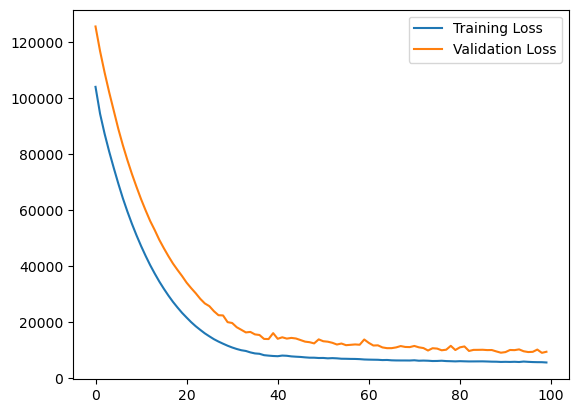

In [10]:
# Plot the training and validation loss
def plot_loss(history):
    import matplotlib.pyplot as plt

    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.show()

plot_loss(history)

In [ ]:
# Save the model
model.save("model.keras")